# Scala's real-world project repository data

In this project, I'm going to read in, clean up, and visualize the real world project repository of Scala that spans data from a version control system (Git) as well as a project hosting site (GitHub). 

I will find out who has had the most influence on its development and who are the experts.
The dataset is comprised of three files:

* pulls_2011-2013.csv : contains the basic information about the pull requests, and spans from the end of 2011 up to (but not including) 2014
* pulls_2014-2018.csv contains identical information, and spans from 2014 up to 2018
* pull_files.csv contains the files that were modified by each pull request
​

In [4]:
from google.colab import files
 
uploaded = files.upload()

Saving pull_files.csv to pull_files.csv
Saving pulls.csv to pulls.csv
Saving pulls_2011-2013.csv to pulls_2011-2013.csv
Saving pulls_2014-2018.csv to pulls_2014-2018.csv


In [5]:
import pandas as pd

# Loading in the data
pulls_one =pd.read_csv("pulls_2011-2013.csv")
pulls_two =pd.read_csv("pulls_2014-2018.csv")
pull_files =pd.read_csv("pull_files.csv")

# Preparing and cleaning the data

First, I needed to combine the data from the two separate pull DataFrames.

Next, the raw data extracted from GitHub contained dates in the ISO8601 format. However, pandas imports them as regular strings. To make my analysis easier, I needed to convert the strings into Python's DateTime objects, since DateTime objects have the important property that they can be compared and sorted.

The pull request times are all in UTC, so in order to make comparisons easy, I should convert all times to UTC.

In [ ]:
# Append pulls_one to pulls_two
pulls = pulls_one.append(pulls_two)
print(pulls.head())

# Convert the date for the pulls object
pulls['date'] = pd.to_datetime(pulls['date'],utc=True)
print(pulls.head())

# Merging the DataFrames

The data extracted comes in two separate files, so I merged the two DataFrames to analyze the data in the future tasks.

In [ ]:
# the two DataFrames merged
data =pulls.merge(pull_files,on='pid')
print(data.head())

# Is the project still actively maintained?

The data used in this project was collected in January of 2018, and I'm interested in the evolution of the number of contributions up to that date.

For Scala, I did this by plotting a chart of the project's activity. I calculated the number of pull requests submitted each month during the project's lifetime. And then I plotted these numbers to see the trend of contributions.

In [ ]:
# Column that will store the month
data['month'] = data['date'].dt.month

# Column that will store the year
data['year'] = data['date'].dt.year

# Group by the month and year and count the pull requests
counts = data.groupby(['month','year']).agg({'pid':'count'})
print(data.head())

# The plot of the results
counts.plot(kind='bar', figsize = (12,4))

# Is there camaraderie in the project?

A project that has a very small community might not be the best one to start working on. The small community might indicate a high barrier of entry. However, a large community can serve as an indicator that the project is regularly accepting pull requests from new contributors. Such a project would be a good place to start.

In order to evaluate the dynamics of the community, I plotted a histogram of the number of pull requests submitted by each user. A distribution that shows that there are few people that only contribute a small number of pull requests can be used as in indicator that the project is not welcoming of new contributors. 

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
# Group by the submitter
by_user = data.groupby('user').agg({'pid':'count'})
print(by_user.shape)
# Plot the histogram
by_user['pid'].hist()

# What files were changed in the last ten pull requests?

Choosing the right place to make a contribution is as important as choosing the project to contribute to. Some parts of the code might be stable, some might be dead. Contributing there might not have the most impact. Therefore it is important to understand the parts of the system that have been recently changed.

In [14]:
# Identify the last 10 pull requests
last_10 = pulls.nlargest(10,'date')
print(last_10.shape)

# Join the two data sets
joined_pr = last_10.merge(pull_files,on='pid')
print(joined_pr.shape)
# Identify the unique files
files = set(joined_pr['file'].unique())

# Print the results
files

(10, 3)
(34, 4)


{'LICENSE',
 'doc/LICENSE.md',
 'doc/License.rtf',
 'project/VersionUtil.scala',
 'src/compiler/scala/reflect/reify/phases/Calculate.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/BCodeHelpers.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/PostProcessor.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/analysis/BackendUtils.scala',
 'src/compiler/scala/tools/nsc/profile/AsyncHelper.scala',
 'src/compiler/scala/tools/nsc/profile/Profiler.scala',
 'src/compiler/scala/tools/nsc/symtab/classfile/ClassfileParser.scala',
 'src/compiler/scala/tools/nsc/typechecker/Contexts.scala',
 'src/library/scala/Predef.scala',
 'src/library/scala/concurrent/Lock.scala',
 'src/library/scala/util/Properties.scala',
 'src/reflect/scala/reflect/internal/pickling/ByteCodecs.scala',
 'src/reflect/scala/reflect/internal/tpe/GlbLubs.scala',
 'src/scaladoc/scala/tools/nsc/doc/html/page/Entity.scala',
 'src/scalap/decoder.properties',
 'test/files/neg/leibniz-liskov.check',
 'test/files/neg/leibniz-liskov

# Who made the most pull requests to a given file?

When contributing to a project, I might need some guidance, so it was important to address my questions to the right people. One way to identify the right target for our inquiries is by using their contribution history.

I identified src/compiler/scala/reflect/reify/phases/Calculate.scala as being recently changed. Then, I was interested in the top 3 developers who changed that file.

In [13]:
# This is the file we are interested in:
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Identify the commits that changed the file
file_pr = data[data['file']==file]

# Count the number of changes made by each developer
author_counts = file_pr.groupby('user').agg({'user':'count'})

# Print the top 3 developers
print(author_counts.nlargest(3,'user'))

          user
user          
xeno-by     11
retronym     5
soc          4


# Who made the last ten pull requests on a given file?

Open source projects suffer from fluctuating membership. This makes the problem of finding the right person more challenging: the person has to be knowledgeable and still be involved in the project. A person that contributed a lot in the past might no longer be available to help. To get a better understanding, I needed to investigate the more recent history of that particular part of the system, I looked at the history of src/compiler/scala/reflect/reify/phases/Calculate.scala

In [15]:
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Select the pull requests that changed the target file
file_pr = pull_files[pull_files['file']==file]

# Merge the obtained results with the pulls DataFrame
joined_pr = pulls.merge(file_pr,on='pid')

# Find the users of the last 10 most recent pull requests
users_last_10 =set(joined_pr.nlargest(10,'date')['user'])

# Printing the results
users_last_10

{'bjornregnell', 'retronym', 'soc', 'starblood', 'xeno-by', 'zuvizudar'}

# The pull requests of two special developers

I identified two potential contacts in the projects, so I needed to find the person who was most involved in the project in recent times. That person is most likely to answer my questions

       user  date  pid
0       soc  2011   12
1       soc  2012   44
2       soc  2013  117
3       soc  2014   20
4       soc  2015   24
5       soc  2016   21
6   xeno-by  2011   20
7   xeno-by  2012  271
8   xeno-by  2013  123
9   xeno-by  2014   60
10  xeno-by  2015    3


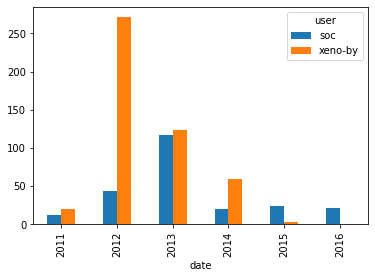

In [16]:
import matplotlib.pyplot as plt

# The developers I am interested in
authors = ['xeno-by', 'soc']

# Get all the developers' pull requests
by_author = pulls[pulls['user'].isin(authors)]

# Count the number of pull requests submitted each year
counts = by_author.groupby([by_author['user'],by_author['date'].dt.year]).agg({'pid': 'count'}).reset_index()

# Convert the table to a wide format
counts_wide = counts.pivot_table(index='date', columns='user', values='pid', fill_value=0)
print(counts)

# Plot the results
counts_wide.plot(kind='bar')

# Visualizing the contributions of each developer

As mentioned before, it is important to make a distinction between the global expertise and contribution levels and the contribution levels at a more granular level (file, submodule, etc.) 

In my case, I wanted to see which of my two developers of interest have the most experience with the code in a given file. So I measured experience by the number of pull requests submitted that affect that file and how recent those pull requests were submitted.

      user  date  pid
0      soc  2012    2
1      soc  2013    2
2  xeno-by  2012   10
3  xeno-by  2014    1
user  soc  xeno-by
date              
2012    2       10
2013    2        0
2014    0        1


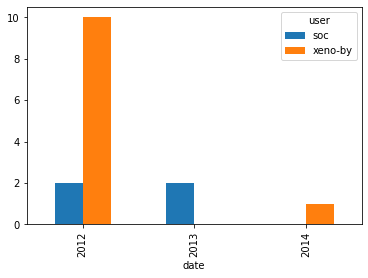

In [17]:
authors = ['xeno-by', 'soc']
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Select the pull requests submitted by the authors, from the `data` DataFrame
by_author = data[data['user'].isin(authors)]

# Select the pull requests that affect the file
by_file = by_author[by_author['file']==file]

# Group and count the number of PRs done by each user each year
grouped = by_file.groupby(['user', by_file['date'].dt.year]).count()['pid'].reset_index()
print(grouped)

# Transform the data into a wide format
by_file_wide = grouped.pivot_table(values='pid',index='date',columns='user', fill_value=0)
print(by_file_wide)

# Plot the results
by_file_wide.plot(kind='bar')